In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize

dat = pd.read_parquet('ebay_ho2.parquet')

var_labels = {'anon_item_id': 'Anonymized listing ID',
              'anon_leaf_categ_id': 'Anonymized leaf category ID, a finer categorization than meta categor',
              'fdbk_pstv_start':'sellers percent feedback score at the time of the listin',
              'start_price_usd': 'Buy-It-Now price', 'photo_count': 'Number of photos in listing', 
              'to_lst_cnt': 'Number of listings created by the seller dating back to 2008',
              'bo_lst_cnt': 'Number of BO-listings created by the seller dating back to 2008',
              'item_cndtn_id': 'Indicator for the new/used status of the item',
              'view_item_count': 'Number of times the item page was viewed',
              'wtchr_count': 'Number of users who selected the "add to watch list" option for this listing',              
              'anon_product_id': 'Anonymized product ID, only available for items that can be linked to specific cataloged products', 
              'count1': 'Number of listings used in creating ref_price1 for this observation',
              'ref_price1': 'Average price for sold fixed price listings with the same listing title as this item, sold during the time frame of the data',   
              'item_price': 'Final price (Buy-It-Now price if the item sold through Buy-It-Now option, or the final negotiated price if the item sold through Best Offer. ',
              'bo_ck_yn': 'Indicator for whether item sold through best offer.',
              'decline_price': 'Price chosen by seller, if the seller chooses to report one, below which any offer will be automatically rejected', 
              'accept_price': 'Price chosen by seller, if the seller chooses to report one, above which any offer will be automatically accepted', 
              'bin_rev': 'Indicator for whether the Buy-It-Now price was ever modified by the seller during the time the item was listed', 
              'lstg_gen_type_id': 'Indicator for whether the item is a re-listing (i.e. an item that failed to sell before and was then re-listed by the seller)', 
              'store': 'Indicator for whether the listing is part of an eBay store',
              'slr_us': 'Indicator for whether seller is located in US or not', 
              'buyer_us': 'Indicator for whether buyer is located in US or not', 
              'metacat': 'Product category (broad)', 
              'item_condition': 'Indicator for the new/used status of the item (categorical).', 
              'price2ref': 'Price relative to avg. among identical products (ref_price1)', 
              'price2start': 'Price relative to starting price (start_price_usd)'
             }

for v in dat.columns: 
    print(f'{v:<20}: {var_labels[v]}')

# create cols
dat['price2ref']   = dat['item_price'] / dat['ref_price1']
dat['price2start'] = dat['item_price'] / dat['start_price_usd']

price_vars = ['item_price', 'price2ref', 'price2start']

price_labs = {'price2ref':'Price rel. to avg. for product', 'price2start':'Price rel. to starting price', 
              'item_price':'Price (USD)'}


# price to start
#d = dat.groupby('metacat')[['price2start', 'view_item_count']].mean()

dat

anon_product_id     : Anonymized product ID, only available for items that can be linked to specific cataloged products
anon_leaf_categ_id  : Anonymized leaf category ID, a finer categorization than meta categor
fdbk_pstv_start     : sellers percent feedback score at the time of the listin
start_price_usd     : Buy-It-Now price
photo_count         : Number of photos in listing
to_lst_cnt          : Number of listings created by the seller dating back to 2008
bo_lst_cnt          : Number of BO-listings created by the seller dating back to 2008
count1              : Number of listings used in creating ref_price1 for this observation
ref_price1          : Average price for sold fixed price listings with the same listing title as this item, sold during the time frame of the data
view_item_count     : Number of times the item page was viewed
wtchr_count         : Number of users who selected the "add to watch list" option for this listing
item_price          : Final price (Buy-It-Now price 

,anon_product_id,anon_leaf_categ_id,fdbk_pstv_start,start_price_usd,photo_count,to_lst_cnt,bo_lst_cnt,count1,ref_price1,view_item_count,...,accept_price,bin_rev,lstg_gen_type_id,store,slr_us,buyer_us,metacat,item_condition,price2ref,price2start
listing_id,,,,,,,,,,,,,,,,,,,,,
0,547957,10096,99.96,18.00,1,8571,937,0.0,12.00,49,...,True,True,True,True,True,True,Music,Used,1.0,0.666667
1,547957,10096,99.90,5.00,1,47269,16440,0.0,2.50,1,...,True,False,True,True,True,True,Music,Used,1.0,0.500000
2,547957,10096,100.00,60.00,5,11,10,0.0,35.00,10,...,True,False,True,False,True,True,Music,Used,1.0,0.583333
3,547957,10096,99.97,89.95,1,72784,70,0.0,75.00,21,...,False,False,True,True,True,True,Music,Used,1.0,0.833797
4,547957,10096,99.90,14.95,1,9924,1029,0.0,10.00,13,...,True,False,True,False,True,True,Music,Used,1.0,0.668896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7903474,547957,14984,98.83,9.99,1,310,163,NaN,NaN,1,...,True,False,True,True,True,False,Jewelry & Watches,New,NaN,0.570571
7903475,547957,17907,99.02,20.00,1,566,412,NaN,NaN,1,...,True,False,True,True,True,False,Jewelry & Watches,New,NaN,0.550000
7903476,547957,5060,99.96,16.50,1,18420,5737,0.0,12.00,120,...,True,True,True,True,True,True,Sports Mem Cards & Fan Shop,NaN,1.0,0.727273


In [2]:
d = dat.groupby('metacat')[['price2start', 'view_item_count']].mean()
d

C:\Users\bjorn\AppData\Local\Temp\ipykernel_28012\3995507957.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = dat.groupby('metacat')[['price2start', 'view_item_count']].mean()


,price2start,view_item_count
metacat,,
Antiques,0.697898,45.201430
Art,0.678380,33.178491
Baby,0.759839,38.750195
Books,0.697726,19.118065
Business & Industrial,0.720395,36.085501
Cameras & Photo,0.795037,52.978987
Cell Phones & Accessories,0.842814,64.304693
Coins & Paper Money,0.794811,31.213884
Computers/Tablets & Networking,0.796257,45.466562


# 3.2

In [3]:
# d contains one row per metacat with
#   - price2start (avg. realised price / start price)  -> "data" column
#   - view_item_count (avg. page views)                -> input to model
# ----------------------------------------------------------------------

# 1. Teoretisk forudsigelse som funktion af antal views og x
def predicted_price(n_views, x):
    """
    E[V_(n-1)] for Uniform(0,1) værdier, SPSB,
    hvor kun x*100 % af de besøgende byder.
    Kan tage både scalars og Pandas-Series.
    """
    n = x * n_views                     # faktiske bydere
    return (n - 1) / (n + 1)            # (n-1)/(n+1)

# 2. Indsæt forudsigelsen i d for x = 0.20
x = 0.20
d["p_pred"] = predicted_price(d["view_item_count"], x)

# 3. Residualer og RMSE (valgfri men ofte nyttig)
d["diff"] = d["price2start"] - d["p_pred"]           # data – model
rmse = np.sqrt((d["diff"]**2).mean())
print(f"RMSE for x = {x:.2f}: {rmse:.4f}")

# 4. Se resultatet
d.to_latex()       # eller display(d) i Jupyter for hele tabellen


RMSE for x = 0.20: 0.0815


'\\begin{tabular}{lrrrr}\n\\toprule\n & price2start & view_item_count & p_pred & diff \\\\\nmetacat &  &  &  &  \\\\\n\\midrule\nAntiques & 0.697898 & 45.201430 & 0.800802 & -0.102904 \\\\\nArt & 0.678380 & 33.178491 & 0.738072 & -0.059692 \\\\\nBaby & 0.759839 & 38.750195 & 0.771430 & -0.011591 \\\\\nBooks & 0.697726 & 19.118065 & 0.585373 & 0.112353 \\\\\nBusiness & Industrial & 0.720395 & 36.085501 & 0.756605 & -0.036211 \\\\\nCameras & Photo & 0.795037 & 52.978987 & 0.827524 & -0.032487 \\\\\nCell Phones & Accessories & 0.842814 & 64.304693 & 0.855710 & -0.012896 \\\\\nCoins & Paper Money & 0.794811 & 31.213884 & 0.723863 & 0.070948 \\\\\nComputers/Tablets & Networking & 0.796257 & 45.466562 & 0.801849 & -0.005592 \\\\\nConsumer Electronics & 0.778015 & 53.906686 & 0.830240 & -0.052225 \\\\\nCrafts & 0.723743 & 26.663230 & 0.684176 & 0.039567 \\\\\nDVDs & Movies & 0.743048 & 17.834471 & 0.562066 & 0.180982 \\\\\nDolls & Bears & 0.729141 & 36.375775 & 0.758313 & -0.029172 \\\\\nEnte

# 3.3

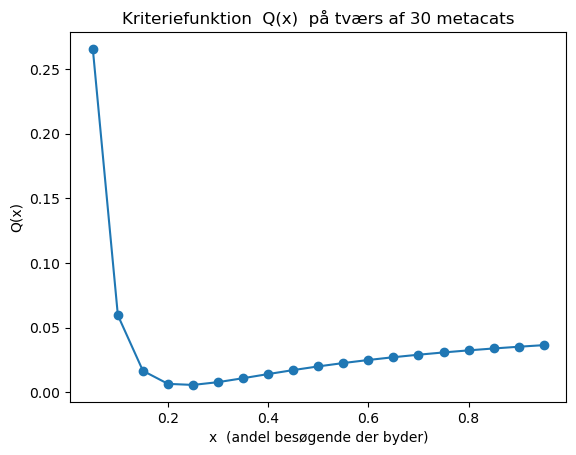

Estimeret andel   x̂  = 0.2318
Kriterieværdi     Q(x̂) = 0.005594


In [4]:
# -------------------------------------------------------------------
# 3.3  –  Find  x̂  that minimises the mean-squared residual Q(x)
# -------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar          # SciPy is already used in bimatrix.py

# --- 1. Objective ---------------------------------------------------
def Q(x, views=d["view_item_count"], price_data=d["price2start"]):
    """
    Mean squared error between model and data for a given share x of
    visitors who bid.  Works directly on the grouped-by DataFrame *d*.
    """
    p_pred = predicted_price(views, x)
    return np.mean((p_pred - price_data) ** 2)      # == equation in assignment

# --- 2. Coarse grid to visualise the criterion ----------------------
x_grid = np.linspace(0.05, 0.95, 19)               # 0.05, 0.10, …, 0.95
Q_grid = [Q(x) for x in x_grid]

plt.plot(x_grid, Q_grid, marker="o")
plt.xlabel("x  (andel besøgende der byder)")
plt.ylabel("Q(x)")
plt.title("Kriteriefunktion  Q(x)  på tværs af 30 metacats")
plt.show()

# Use the best grid point as starting value for the optimiser
x_start = x_grid[int(np.argmin(Q_grid))]

# --- 3. One-dimensional bounded minimisation ------------------------
opt = minimize_scalar(Q, bounds=(0.0, 1.0), method="bounded",
                      options={"xatol": 1e-4}, bracket=(x_start,))

x_hat, Q_hat = opt.x, opt.fun

print(f"Estimeret andel   x̂  = {x_hat:.4f}")
print(f"Kriterieværdi     Q(x̂) = {Q_hat:.6f}")


# 3.4

n̄_c = 64.30   →   n bidders = 15
Simulated mean : 0.874
Observed  mean : 0.843


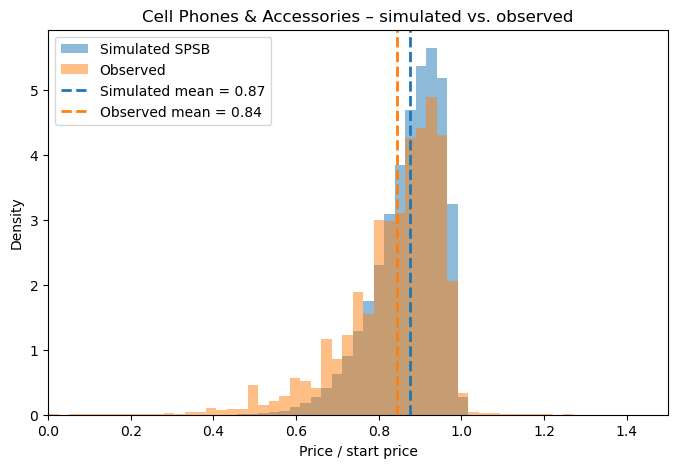

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- pick the category ------------------------------------------------
df_cell = dat[dat["metacat"] == "Cell Phones & Accessories"].copy()

# --- estimated number of bidders --------------------------------------
nc       = df_cell["view_item_count"].mean(skipna=True)          # avg. views
n_bidder = max(2, int(round(x_hat * nc)))                       # round(x̂·nc), min 2
print(f"n̄_c = {nc:.2f}   →   n bidders = {n_bidder}")

# --- simulate second-highest order statistic --------------------------
R          = 100_000
sim_prices = np.random.beta(n_bidder - 1, 2, size=R)

# --- observed prices in the same scale --------------------------------
actual = df_cell["price2start"].dropna().values

# --- compute means ----------------------------------------------------
mean_sim   = sim_prices.mean()
mean_obs   = actual.mean()
print(f"Simulated mean : {mean_sim:.3f}")
print(f"Observed  mean : {mean_obs:.3f}")

# --- main overlap plot (0–1.5) ----------------------------------------
bins_main = np.linspace(0, 1.5, 60)

plt.figure(figsize=(8, 5))
plt.hist(sim_prices,            bins=bins_main, density=True, alpha=0.5,
         label="Simulated SPSB")
plt.hist(actual[actual <= 1.5], bins=bins_main, density=True, alpha=0.5,
         label="Observed")

# vertical dashed lines at the means
plt.axvline(mean_sim, color='tab:blue',  linestyle='--', linewidth=2,
            label=f"Simulated mean = {mean_sim:.2f}")
plt.axvline(mean_obs, color='tab:orange', linestyle='--', linewidth=2,
            label=f"Observed mean = {mean_obs:.2f}")

plt.xlabel("Price / start price")
plt.ylabel("Density")
plt.title("Cell Phones & Accessories – simulated vs. observed")
plt.xlim(0, 1.5)
plt.legend()
plt.grid(False)
plt.show()



# 3.5

[Stamps]  n̄_c = 18.25  →  n bidders = 4
Simulated mean : 0.599
Observed  mean : 0.723
KS-statistic   : 0.300   (p = 0.0000)


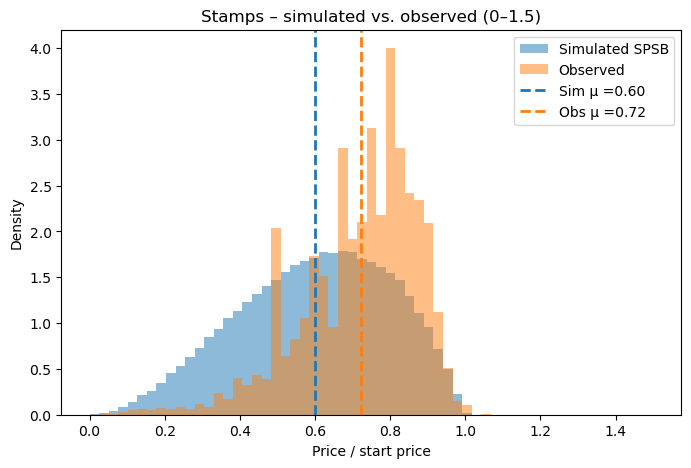

In [6]:
# hypothesis fewer viewers and not so substituable goods gives worse fit 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp       # optional goodness-of-fit test

# ------------------------------------------------------------
# 1.  Pick the “Stamps” category
# ------------------------------------------------------------
target_name = "Stamps"                # adjust if your label differs
df_cat = dat[dat["metacat"] == target_name].copy()
if df_cat.empty:
    raise ValueError(f"No rows found with metacat == '{target_name}'")

# ------------------------------------------------------------
# 2.  Imply bidder count from  x̂
# ------------------------------------------------------------
nc        = df_cat["view_item_count"].mean(skipna=True)
n_bidder  = max(2, int(round(x_hat * nc)))
print(f"[{target_name}]  n̄_c = {nc:.2f}  →  n bidders = {n_bidder}")

# ------------------------------------------------------------
# 3.  Simulate R second-highest bids   V_(n-1) ~ Beta(n-1, 2)
# ------------------------------------------------------------
R           = 100_000
sim_prices  = np.random.beta(n_bidder - 1, 2, size=R)

# ------------------------------------------------------------
# 4.  Observed prices (price / start price)
# ------------------------------------------------------------
actual = df_cat["price2start"].dropna().values

# ------------------------------------------------------------
# 5.  Simple summary statistics & KS distance
# ------------------------------------------------------------
print(f"Simulated mean : {sim_prices.mean():.3f}")
print(f"Observed  mean : {actual.mean():.3f}")
D, p_ks = ks_2samp(sim_prices, actual)
print(f"KS-statistic   : {D:.3f}   (p = {p_ks:.4f})")

# ------------------------------------------------------------
# 6.  Overlay histograms  (main support 0–1.5)  + right tail
# ------------------------------------------------------------
bins = np.linspace(0, 1.5, 60)
plt.figure(figsize=(8, 5))
plt.hist(sim_prices,            bins=bins, density=True, alpha=0.5,
         label="Simulated SPSB")
plt.hist(actual[actual <= 1.5], bins=bins, density=True, alpha=0.5,
         label="Observed")
plt.axvline(sim_prices.mean(), color='tab:blue',   ls='--', lw=2,
            label=f"Sim μ ={sim_prices.mean():.2f}")
plt.axvline(actual.mean(),     color='tab:orange', ls='--', lw=2,
            label=f"Obs μ ={actual.mean():.2f}")
plt.xlabel("Price / start price")
plt.ylabel("Density")
plt.title(f"{target_name} – simulated vs. observed (0–1.5)")
plt.legend(); plt.grid(False); plt.show()


In [7]:
# now lets run it for all categories
import numpy as np, pandas as pd
from scipy.stats import ks_2samp

# --- settings -------------------------------------------------------
x_hat = 0.23        # from task 3.3
R     = 100_000     # simulations per category

# --- helper ---------------------------------------------------------
def category_fit(cat, views_mean, x_hat=x_hat, R=R):
    """Return sim_mean, obs_mean, mean_diff, KS statistic for one category."""
    # 1. implied bidder count (≥2)
    n = max(2, int(round(x_hat * views_mean)))
    # 2. simulate second-highest U(0,1) order statistic
    sim = np.random.beta(n - 1, 2, size=R)
    sim_mean = sim.mean()
    # 3. pull observed price/start ratios for that category
    obs = dat.loc[dat["metacat"] == cat, "price2start"].dropna().values
    if len(obs) == 0:
        return np.nan, np.nan, np.nan, np.nan
    obs_mean = obs.mean()
    # 4. KS distance on the full distributions
    ks_stat = ks_2samp(sim, obs, alternative="two-sided", mode="asymp").statistic
    return sim_mean, obs_mean, sim_mean - obs_mean, ks_stat

# --- apply to every row of your summary frame d ---------------------
cols = ["sim_mean", "obs_mean", "mean_diff", "ks_stat"]
d[cols] = (
    d.apply(
        lambda r: pd.Series(
            category_fit(
                cat=r.name,
                views_mean=r["view_item_count"]
            ),
            index=cols
        ),
        axis=1
    )
)

# quick look
d[["sim_mean", "obs_mean", "mean_diff", "ks_stat"]].head()


,sim_mean,obs_mean,mean_diff,ks_stat
metacat,,,,
Antiques,0.817918,0.697898,0.120020,0.363132
Art,0.777337,0.678380,0.098956,0.263541
Baby,0.799845,0.759839,0.040006,0.155088
Books,0.600874,0.697726,-0.096852,0.247825
Business & Industrial,0.778330,0.720395,0.057935,0.167778


In [8]:
d.columns

Index(['price2start', 'view_item_count', 'p_pred', 'diff', 'sim_mean',
       'obs_mean', 'mean_diff', 'ks_stat'],
      dtype='object')

In [9]:
# ------------------------------------------------------------
# 1.  Add category-level features of interest
# ------------------------------------------------------------
cat_feats = (
    dat.groupby("metacat")
       .agg(
           views_mean   = ("view_item_count", "mean"),
           photo_mean   = ("photo_count",     "mean"),
           seller_exp   = ("to_lst_cnt",      "mean"),   # seller experience
           store_share  = ("store",           "mean"),   # % of listings from stores
       )
)

# Merge with the existing summary d (index = metacat)
d_full = (
    d.join(cat_feats, how="left")        # d already has ks_stat, mean_diff, …
      .rename_axis("metacat")            # keep index label tidy
)
d_full

C:\Users\bjorn\AppData\Local\Temp\ipykernel_28012\3616471069.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dat.groupby("metacat")


,price2start,view_item_count,p_pred,diff,sim_mean,obs_mean,mean_diff,ks_stat,views_mean,photo_mean,seller_exp,store_share
metacat,,,,,,,,,,,,
Antiques,0.697898,45.201430,0.800802,-0.102904,0.817918,0.697898,0.120020,0.363132,45.201430,5.672668,9318.728728,0.575888
Art,0.678380,33.178491,0.738072,-0.059692,0.777337,0.678380,0.098956,0.263541,33.178491,3.702322,122372.012575,0.499902
Baby,0.759839,38.750195,0.771430,-0.011591,0.799845,0.759839,0.040006,0.155088,38.750195,2.652857,6979.726981,0.376948
Books,0.697726,19.118065,0.585373,0.112353,0.600874,0.697726,-0.096852,0.247825,19.118065,2.660783,47189.851484,0.573344
Business & Industrial,0.720395,36.085501,0.756605,-0.036211,0.778330,0.720395,0.057935,0.167778,36.085501,3.420352,13889.926696,0.477521
Cameras & Photo,0.795037,52.978987,0.827524,-0.032487,0.845896,0.795037,0.050859,0.176598,52.978987,4.140708,5707.506400,0.351628
Cell Phones & Accessories,0.842814,64.304693,0.855710,-0.012896,0.875111,0.842814,0.032298,0.139000,64.304693,3.247344,2898.040914,0.230654
Coins & Paper Money,0.794811,31.213884,0.723863,0.070948,0.750202,0.794811,-0.044609,0.174497,31.213884,2.532019,14812.845022,0.537944
Computers/Tablets & Networking,0.796257,45.466562,0.801849,-0.005592,0.817927,0.796257,0.021670,0.072736,45.466562,2.934380,7768.041822,0.379332


In [10]:
# ------------------------------------------------------------
# 0.  Prerequisites
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import ks_2samp

# dat  ........ original listing-level DataFrame
# d    ........ category summary that already contains ks_stat, etc.
#            (see code from previous step ― mean_diff / ks_stat columns)

# ------------------------------------------------------------
# 1.  Add category-level features of interest
# ------------------------------------------------------------
cat_feats = (
    dat.groupby("metacat")
       .agg(
           views_mean   = ("view_item_count", "mean"),
           photo_mean   = ("photo_count",     "mean"),
           seller_exp   = ("to_lst_cnt",      "mean"),   # seller experience
           store_share  = ("store",           "mean")   # % of listings from stores
           #n_listings   = ("anon_item_id",    "size")    # sample size (weight)
       )
)

# Merge with the existing summary d (index = metacat)
d_full = (
    d.join(cat_feats, how="left")        # d already has ks_stat, mean_diff, …
      .rename_axis("metacat")            # keep index label tidy
)

# ------------------------------------------------------------
# 2.  Prepare data for OLS
#     • Dependent:  ks_stat  (goodness-of-fit, lower = better)
#     • Regressors: log-transformed levels to dampen skewness
# ------------------------------------------------------------
vars_x = ["views_mean", "photo_mean", "seller_exp", "store_share"]

X = np.log1p(d_full[vars_x])             # log(1+x)   (store_share already ∈[0,1], but harmless)
X = sm.add_constant(X)                   # add constant term
y = -d_full["ks_stat"]  # i change this to negative ks_stat we want to predict good fit not bad fit

# drop any categories with missing values
mask = y.notna() & X.notna().all(axis=1)
X, y = X.loc[mask], y.loc[mask]

# ------------------------------------------------------------
# 3.  Run OLS with HC3 robust s.e.
# ------------------------------------------------------------
model = sm.OLS(y, X).fit(cov_type="HC3")
print(model.summary())


C:\Users\bjorn\AppData\Local\Temp\ipykernel_28012\2389760676.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dat.groupby("metacat")


                            OLS Regression Results                            
Dep. Variable:                ks_stat   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                     1.041
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.406
Time:                        23:39:49   Log-Likelihood:                 29.943
No. Observations:                  30   AIC:                            -49.89
Df Residuals:                      25   BIC:                            -42.88
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4799      0.724     -0.663      

# PART B

In [11]:
price_var = 'price2ref'

I = (dat.metacat == 'Cell Phones & Accessories') & (dat.price2ref < 2.0) & (dat.count1 >= 10)
d = dat[I].copy() # to avoid having a pointer 

# B1

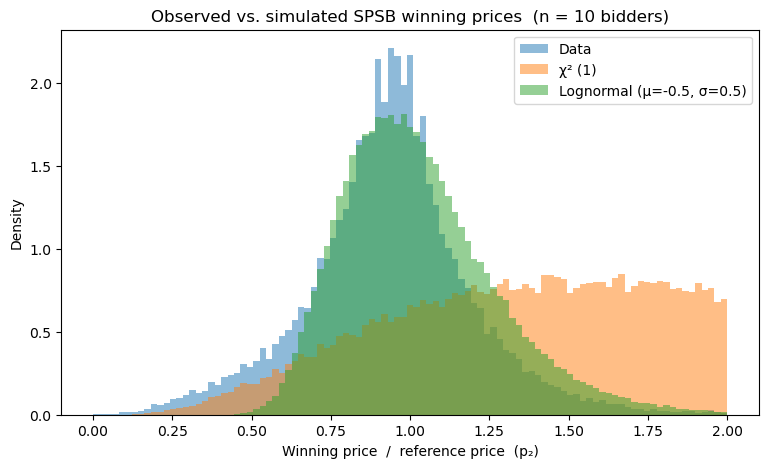

In [12]:
# ------------------------------------------------------------
# B.1  –  Simulate winning payments for n = 10 bidders
#         under two alternative valuation distributions
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

price_var = "price2ref"                     # <- already chosen in the scaffold
data_prices = d[price_var].values           # observed winning payments

n = 10
R = 100_000

# ---- (a) Chi-square(1) valuations -----------------------------------
v = np.random.chisquare(df=1, size=(n, R))      # shape (n, R)
win_chi2 = np.sort(v, axis=0)[-2, :]            # second-highest per column

# ---- (b) Lognormal valuations  LN(μ=-0.5, σ=0.5) --------------------
w = np.exp(np.random.normal(-0.5, 0.5, size=(n, R)))
win_lognorm = np.sort(w, axis=0)[-2, :]

# ------------------------------------------------------------
# Plot: data vs. simulated winning prices
# ------------------------------------------------------------
bins = np.linspace(0, 2.0, 100)    # same upper bound the data were trimmed at

plt.figure(figsize=(9, 5))
plt.hist(data_prices,   bins=bins, density=True, alpha=0.5, label="Data")
plt.hist(win_chi2,      bins=bins, density=True, alpha=0.5, label="χ² (1)")
plt.hist(win_lognorm,   bins=bins, density=True, alpha=0.5, label="Lognormal (μ=-0.5, σ=0.5)")
plt.xlabel("Winning price  /  reference price  (p₂)")
plt.ylabel("Density")
plt.title("Observed vs. simulated SPSB winning prices  (n = 10 bidders)")
plt.legend()
plt.grid(False)
plt.show()


# B2

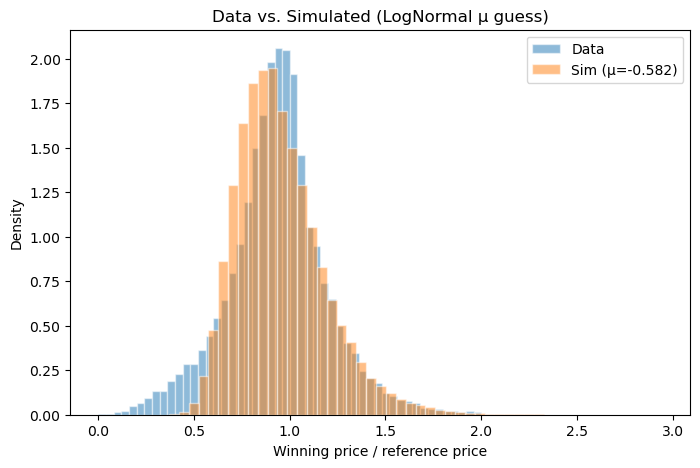

at x = 1.2, CDF data = 0.873, CDF sim = 0.865


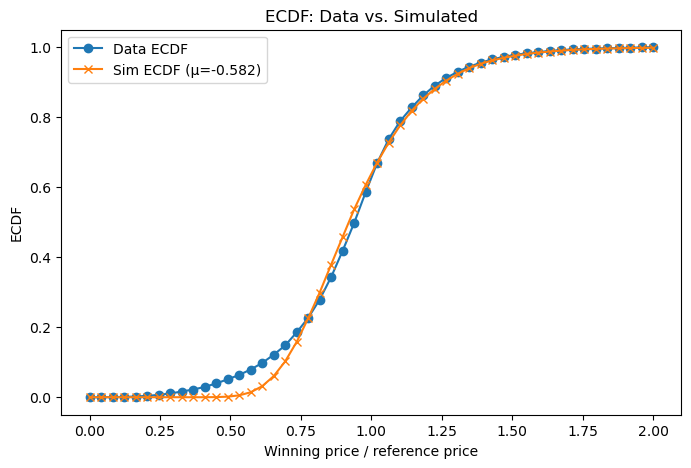

Distance at μ = -0.582: 0.000604
Estimated μ̂ = -0.5820,  Q(μ̂) = 6.042071e-04


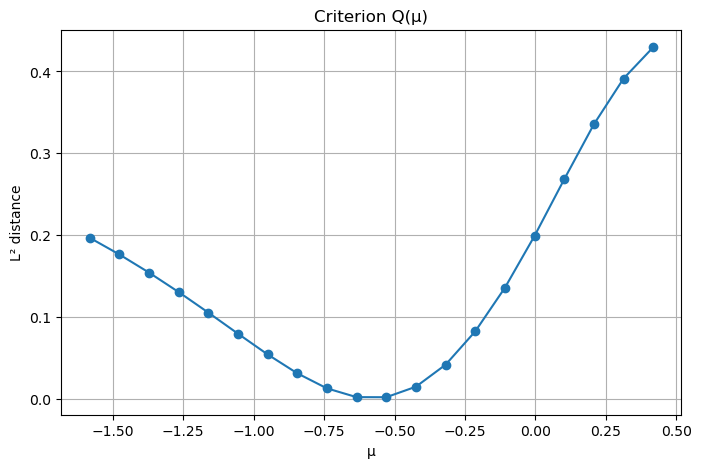

In [13]:
# PRED MEAN

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize

# --- 0. Prepare data --------------------------------------------
price_var = "price2ref"
x = d[price_var].dropna().values    # observed winning prices, N values
N = len(x)

# --- 1. Simulation function -------------------------------------
R = 100_000
n = 10
sigma_hat = 0.505                   # fixed at your joint estimate

def predict_distribution(mu):
    np.random.seed(1337)            # reproducibility
    # draw valuations ~ LogNormal(mu, sigma_hat)
    v = np.exp(np.random.normal(mu, sigma_hat, size=(R, n)))
    # second-highest of each row
    w = np.sort(v, axis=1)[:, -2]
    return w

# --- 2. Quick histogram check -----------------------------------
mu_guess = -0.582
y = predict_distribution(mu_guess)

plt.figure(figsize=(8,5))
plt.hist(x, alpha=0.5, bins=50, density=True, edgecolor='w', label='Data')
plt.hist(y, alpha=0.5, bins=50, density=True, edgecolor='w', label=f'Sim (μ={mu_guess})')
plt.xlabel("Winning price / reference price")
plt.ylabel("Density")
plt.title("Data vs. Simulated (LogNormal μ guess)")
plt.legend()
plt.show()

# --- 3. ECDF comparison -----------------------------------------
f_data = ECDF(x)
f_sim  = ECDF(y)

this_x = 1.2
print(f'at x = {this_x}, CDF data = {f_data(this_x):.3f}, CDF sim = {f_sim(this_x):.3f}')

G = 50
xx = np.linspace(0, 2, G)

plt.figure(figsize=(8,5))
plt.plot(xx, f_data(xx), '-o', label='Data ECDF')
plt.plot(xx, f_sim(xx),  '-x', label=f'Sim ECDF (μ={mu_guess})')
plt.xlabel("Winning price / reference price")
plt.ylabel("ECDF")
plt.title("ECDF: Data vs. Simulated")
plt.legend()
plt.show()

# --- 4. Define L² criterion and optimize ------------------------
def Q(mu):
    w = predict_distribution(mu)
    f_sim = ECDF(w)
    dist = (f_data(xx) - f_sim(xx))**2
    return np.mean(dist)

print(f'Distance at μ = {mu_guess}: {Q(mu_guess):.6f}')

mu0 = mu_guess
res = minimize(Q, x0=[mu0], bounds=[(-2, 2)], method='L-BFGS-B')
mu_hat = res.x[0]
print(f'Estimated μ̂ = {mu_hat:.4f},  Q(μ̂) = {res.fun:.6e}')

# --- 5. Plot Q(μ) over a grid -------------------------------------
mm = np.linspace(mu_hat-1, mu_hat+1, 20)
yy = np.array([Q(mu) for mu in mm])

plt.figure(figsize=(8,5))
plt.plot(mm, yy, '-o')
plt.xlabel("μ")
plt.ylabel("L² distance")
plt.title("Criterion Q(μ)")
plt.grid()
plt.show()


Distance at σ = 0.505: 0.000604
Estimated σ̂ = 0.5050,  Q(σ̂) = 6.042071e-04


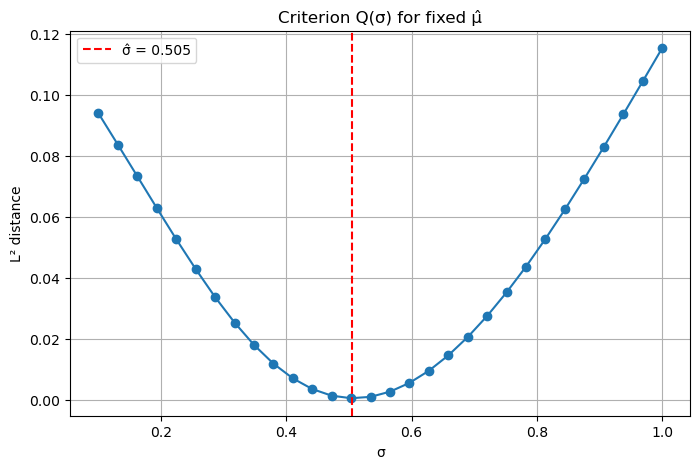

In [14]:
# PRED VARIANCE

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize

# --- 0. Data and fixed μ ----------------------------------------
price_var = "price2ref"
x = d[price_var].dropna().values
ecdf_data = ECDF(x)
N = len(x)

mu_hat = -0.5820       # fixed from earlier
n, R = 10, 100_000
xx = np.linspace(0, 2, 50)

# --- 1. Prediction function varying σ ---------------------------
def predict_distribution_sigma(sigma):
    np.random.seed(1337)
    v = np.exp(np.random.normal(mu_hat, sigma, size=(R, n)))
    w = np.sort(v, axis=1)[:, -2]
    return w

# --- 2. L² criterion as function of σ ----------------------------
def Q_sigma(sigma):
    w = predict_distribution_sigma(sigma)
    ecdf_sim = ECDF(w)
    return np.mean((ecdf_data(xx) - ecdf_sim(xx))**2)

# --- 3. Evaluate at initial σ ------------------------------------
sigma0 = 0.505
print(f"Distance at σ = {sigma0}: {Q_sigma(sigma0):.6f}")

# --- 4. Optimize σ with bounds -----------------------------------
res = minimize(Q_sigma, x0=[sigma0], bounds=[(1e-3, 2.0)], method='L-BFGS-B')
sigma_hat = res.x[0]
print(f"Estimated σ̂ = {sigma_hat:.4f},  Q(σ̂) = {res.fun:.6e}")

# --- 5. Plot Q(σ) over a grid ------------------------------------
sigmas = np.linspace(0.1, 1.0, 30)
Q_vals = [Q_sigma(s) for s in sigmas]

plt.figure(figsize=(8,5))
plt.plot(sigmas, Q_vals, '-o')
plt.axvline(sigma_hat, color='red', linestyle='--',
            label=f"σ̂ = {sigma_hat:.3f}")
plt.xlabel("σ")
plt.ylabel("L² distance")
plt.title("Criterion Q(σ) for fixed μ̂")
plt.legend(); plt.grid(); plt.show()


# B3

b*(0.5) = 0.4737
b*(1.0) = 0.8538


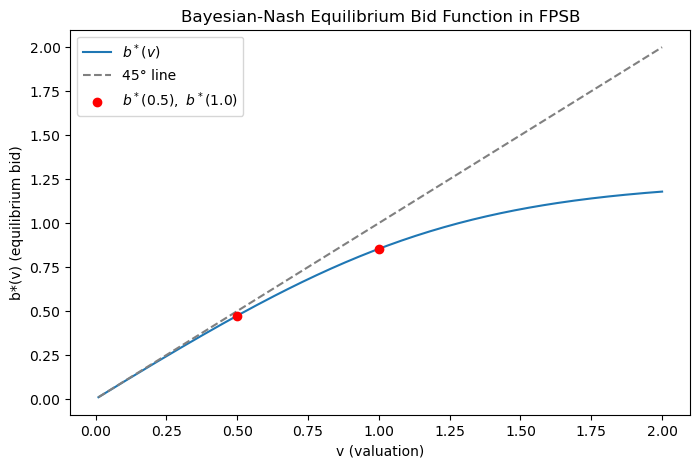

In [15]:
from scipy.integrate import quad
from scipy.stats import lognorm
import numpy as np
import matplotlib.pyplot as plt

# ---- parameters from previous question -------------------------
n = 10
mu_hat    = -0.582
sigma_hat = 0.505

# ---- CDF of the valuation distribution -------------------------
F_cdf = lambda v: lognorm.cdf(v, s=sigma_hat, scale=np.exp(mu_hat))

# ---- equilibrium bid function under revenue equivalence --------
def b_star(v, F_cdf, n):
    if v <= 0: return 0.0
    numer = quad(lambda x: F_cdf(x)**(n - 1), 0, v)[0]
    denom = F_cdf(v)**(n - 1)
    return v - numer / denom

# ---- Evaluate at v = 0.5 and v = 1.0 ---------------------------
v_points = [0.5, 1.0]
b_points = [b_star(v, F_cdf, n) for v in v_points]
for v, b in zip(v_points, b_points):
    print(f"b*({v}) = {b:.4f}")

# ---- Plot the bid function -------------------------------------
vs = np.linspace(0.01, 2.0, 200)
bs = [b_star(v, F_cdf, n) for v in vs]

plt.figure(figsize=(8, 5))
plt.plot(vs, bs, label=r"$b^*(v)$")
plt.plot(vs, vs, '--', color='gray', label="45° line")

# Add red dots at v = 0.5 and v = 1.0
plt.scatter(v_points, b_points, color='red', zorder=5, label=r"$b^*(0.5),\ b^*(1.0)$")

plt.xlabel("v (valuation)")
plt.ylabel("b*(v) (equilibrium bid)")
plt.title("Bayesian-Nash Equilibrium Bid Function in FPSB")
plt.legend()
plt.grid(False)
plt.show()


# B4

Gennemsnitlig betaling SPSB: 0.9514
Gennemsnitlig betaling FPSB: 0.9523


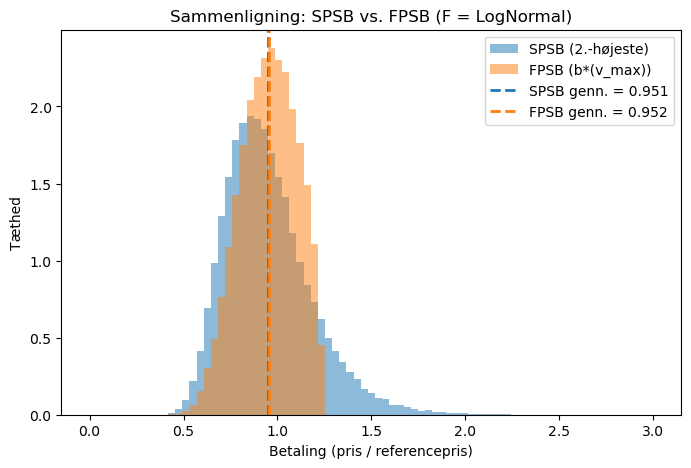

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import lognorm

# ---- 1. Parameters from earlier -----------------------------------
n = 10
R = 100_000
mu_hat    = -0.582
sigma_hat = 0.505

# ---- 2. Define CDF and bid function -------------------------------
F_cdf = lambda v: lognorm.cdf(v, s=sigma_hat, scale=np.exp(mu_hat))

def b_star(v, F_cdf, n):
    if v <= 0:
        return 0.0
    numer = quad(lambda x: F_cdf(x)**(n - 1), 0, v)[0]
    denom = F_cdf(v)**(n - 1)
    return v - numer / denom

# ---- 3. Pre-compute b*(v) on a grid -------------------------------
v_grid = np.linspace(0.0, 3.0, 300)
b_grid = np.array([b_star(v, F_cdf, n) for v in v_grid])

# ---- 4. Simulate valuations ----------------------------------------
vals = np.exp(np.random.normal(mu_hat, sigma_hat, size=(n, R)))

# ---- 5. Extract v_{(n-1)} and v_{(n)} -----------------------------
vals_sorted = np.sort(vals, axis=0)
v_second = vals_sorted[-2, :]
v_max    = vals_sorted[-1, :]

# ---- 6. Interpolate FPSB payment from b_star grid -----------------
v_clamped = np.clip(v_max, v_grid[0], v_grid[-1])
pay_fpsb = np.interp(v_clamped, v_grid, b_grid)

# ---- 7. Define payment vectors -------------------------------------
pay_spsb = v_second

# ---- 8. Compute means and plot -------------------------------------
mean_spsb = pay_spsb.mean()
mean_fpsb = pay_fpsb.mean()

print(f"Gennemsnitlig betaling SPSB: {mean_spsb:.4f}")
print(f"Gennemsnitlig betaling FPSB: {mean_fpsb:.4f}")

bins = np.linspace(0, 3.0, 80)

plt.figure(figsize=(8, 5))
plt.hist(pay_spsb, bins=bins, density=True, alpha=0.5, label="SPSB (2.-højeste)")
plt.hist(pay_fpsb, bins=bins, density=True, alpha=0.5, label="FPSB (b*(v_max))")

plt.axvline(mean_spsb, color="tab:blue", linestyle="--", linewidth=2,
            label=f"SPSB genn. = {mean_spsb:.3f}")
plt.axvline(mean_fpsb, color="tab:orange", linestyle="--", linewidth=2,
            label=f"FPSB genn. = {mean_fpsb:.3f}")

plt.xlabel("Betaling (pris / referencepris)")
plt.ylabel("Tæthed")
plt.title("Sammenligning: SPSB vs. FPSB (F = LogNormal)")
plt.legend()
plt.grid(False)
plt.show()
